In [22]:
import os
import random
from pathlib import Path
import numpy as np

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
label_map = {1: "person"}


In [ ]:
data_root = Path("train_data_generation/data/drive_with_keypress/32")

In [ ]:
train_images_dir = str(data_root / 'train/images')
train_annotations_dir = str(data_root / 'train/annotations')
val_images_dir = str(data_root / 'validation/images')
val_annotations_dir = str(data_root / 'validation/annotations')
test_images_dir = str(data_root / 'test/images')
test_annotations_dir = str(data_root / 'test/annotations')

In [ ]:
train_data = object_detector.DataLoader.from_pascal_voc(
    train_images_dir, train_annotations_dir, label_map=label_map)
validation_data = object_detector.DataLoader.from_pascal_voc(
    val_images_dir, val_annotations_dir, label_map=label_map)
test_data = object_detector.DataLoader.from_pascal_voc(
    test_images_dir, test_annotations_dir, label_map=label_map)

In [ ]:
print(f'train count: {len(train_data)}')
print(f'validation count: {len(validation_data)}')
print(f'test count: {len(test_data)}')

In [ ]:
spec = object_detector.EfficientDetLite0Spec()

In [ ]:
model = object_detector.create(train_data=train_data, 
                               model_spec=spec, 
                               validation_data=validation_data, 
                               epochs=50, 
                               batch_size=10, 
                               train_whole_model=True)

In [ ]:
model.evaluate(test_data)

In [26]:
export_dir = Path('objects_on_road_processor/model')
TFLITE_FILENAME = 'efficientdet-lite.tflite'
LABELS_FILENAME = 'obj_det_labels.txt'

In [ ]:
model.export(export_dir=str(export_dir), tflite_filename=TFLITE_FILENAME, label_filename=LABELS_FILENAME,
             export_format=[ExportFormat.TFLITE, ExportFormat.LABEL])

In [37]:
images_path = test_images_dir
filenames = os.listdir(os.path.join(images_path))
random_index = random.randint(0,len(filenames)-1)
INPUT_IMAGE = os.path.join(images_path, filenames[random_index])

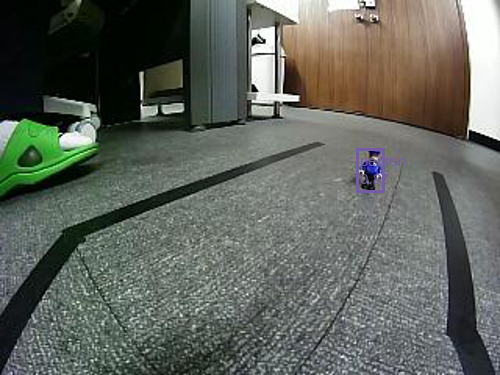

In [38]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

import tflite_runtime.interpreter as tflite 
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype=np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline=color, width=3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size=15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill=color, font=font)

# Load the TF Lite model
labels = read_label_file(str(export_dir / LABELS_FILENAME))
interpreter = tflite.Interpreter(str(export_dir / TFLITE_FILENAME))
interpreter.allocate_tensors()

# Resize the image for input
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold=0.4, image_scale=scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
image

In [40]:
import subprocess

cmd = f"edgetpu_compiler -a -o {export_dir} {export_dir / TFLITE_FILENAME}"
result = subprocess.check_output(cmd, shell = True)
print(result.decode())

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1644 ms.

Input model: objects_on_road_processor/model/efficientdet-lite.tflite
Input size: 4.25MiB
Output model: objects_on_road_processor/model/efficientdet-lite_edgetpu.tflite
Output size: 5.57MiB
On-chip memory used for caching model parameters: 4.21MiB
On-chip memory remaining for caching model parameters: 3.29MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: objects_on_road_processor/model/efficientdet-lite_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Numb